# tfp-multiple-changepoint-detection

Author: Henry Cooksley

Adapted from [Multiple changepoint detection and Bayesian model selection](https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection)

In [18]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

In [34]:
true_rates = [50, 3, 20, 50]
true_durations = [35, 20, 5, 35]
observed_counts = np.concatenate([
    scipy.stats.poisson(rate).rvs(num_steps) 
        for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)
observed_counts

array([35., 41., 43., 60., 39., 46., 50., 57., 50., 41., 39., 53., 43.,
       56., 49., 48., 62., 35., 43., 60., 57., 45., 56., 60., 48., 49.,
       48., 41., 40., 45., 48., 48., 47., 71., 54.,  0.,  0.,  2.,  5.,
        2.,  3.,  3.,  3.,  0.,  4.,  3.,  4.,  2.,  3.,  5.,  4.,  6.,
        2.,  1.,  2., 18., 19., 21., 19., 14., 55., 54., 41., 43., 52.,
       62., 58., 49., 55., 50., 62., 49., 51., 49., 44., 57., 55., 45.,
       45., 51., 56., 48., 49., 48., 59., 61., 48., 56., 64., 41., 35.,
       46., 58., 43., 52.], dtype=float32)

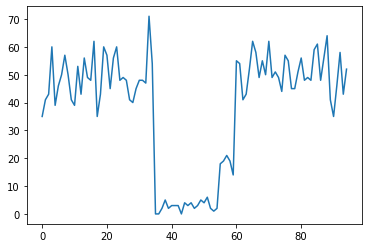

In [35]:
plt.plot(observed_counts);

In [36]:
num_states = 4
initial_state_logits = np.zeros([num_states], dtype=np.float32)
initial_state_logits

array([0., 0., 0., 0.], dtype=float32)

In [37]:
daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
transition_probs

array([[0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667]], dtype=float32)

In [38]:
np.fill_diagonal(transition_probs, 
                 1-daily_change_prob)

In [39]:
print(f"Initial state logits:\n{initial_state_logits}")
print(f"Transition matrix:\n{transition_probs}")

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [40]:
trainable_log_rates = tf.Variable(
    np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(4,) dtype=float32, numpy=array([5.1758966, 4.221461 , 2.1966858, 3.312969 ], dtype=float32)>

In [41]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=initial_state_logits),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[95] dtype=float32>

In [42]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [43]:
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
           hmm.log_prob(observed_counts))

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
optimizer

In [45]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)


In [49]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}: log prob {-loss} rates {rates}")

print("\n")
print(f"Inferred rates: {rates}")
print(f"True rates: {true_rates}")

step 0: log prob -330.08154296875 rates [49.598362 50.280727  2.658044 18.01825 ]
step 20: log prob -330.08154296875 rates [49.598232 50.280727  2.658044 18.01825 ]
step 40: log prob -330.0816345214844 rates [49.598316 50.280693  2.658044 18.01825 ]
step 60: log prob -330.0816955566406 rates [49.598377  50.280727   2.6580439 18.01825  ]
step 80: log prob -330.0816345214844 rates [49.598446  50.280693   2.6580439 18.01825  ]
step 100: log prob -330.0816345214844 rates [49.598446  50.280693   2.6580439 18.01825  ]
step 120: log prob -330.0816345214844 rates [49.598446 50.280693  2.658044 18.01825 ]
step 140: log prob -330.0816345214844 rates [49.598446 50.280693  2.658044 18.01825 ]
step 160: log prob -330.0816345214844 rates [49.598446 50.280693  2.658044 18.01825 ]
step 180: log prob -330.0816345214844 rates [49.598446 50.280693  2.658044 18.01825 ]
step 200: log prob -330.0816345214844 rates [49.598446 50.280693  2.658044 18.01825 ]


Inferred rates: [49.598446 50.280693  2.658044 18.